## Import required packages

In [1]:
from __future__ import print_function, division
import os
import struct
import socket
import pickle

import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchmetrics import PearsonCorrCoef

import scipy.stats as stats
import h5py
import gc
import time
from tqdm import tqdm
import sys
import copy
import csv



# Split 3D Server Side
This code is the server part of split 3D-CNN model for **multi** client and a server.

## Setting variables

In [2]:
!pip install numba
from numba import cuda
device = cuda.get_current_device()
device.reset()

In [3]:
epochs = 10
users = 3 # number of users
batch_size = 5
num_workers = 8

## Set CUDA

In [4]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

torch.manual_seed(777)
if device =="cuda:0":
    torch.cuda.manual_seed_all(777)

## Define 3D CNN model
Client side has **3 convolutional layer**
Server side has **2 convolutional layer**


In [5]:
# define Client Side Layer
class CNN3DModel_client(nn.Module):
    def __init__(self):
        super(CNN3DModel_client, self).__init__()
        
        
        self.client_block = nn.Sequential(
            # First Block
            nn.Conv3d(1, 16, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            
            nn.Conv3d(16, 16, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm3d(16),
            nn.ReLU(),

            nn.MaxPool3d(2),

            # Second Block
            nn.Conv3d(16, 32, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
    
            nn.Conv3d(32, 32, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),

            nn.MaxPool3d(2),

            # Third Block
            nn.Conv3d(32, 64, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),

            nn.Conv3d(64, 64, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),

            nn.MaxPool3d(2),
        )
        
        '''
        self.server_block = nn.Sequential(
            
            # 4th Block
            nn.Conv3d(64, 128, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),

            nn.Conv3d(128, 128, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm3d(128),
            nn.ReLU(),

            nn.MaxPool3d(2),

            # 5th Block
            nn.Conv3d(128, 256, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),

            nn.Conv3d(256, 256, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm3d(256),
            nn.ReLU(),

            nn.MaxPool3d(2),
        )

        self.regressor = nn.Sequential(
            nn.Linear(9216, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1),
        )
        '''
        
    def forward(self,x):
        x = self.client_block(x)
        return x


In [6]:
# define Server Side Layer
class CNN3DModel_server(nn.Module):
    def __init__(self):
        super(CNN3DModel_server, self).__init__()
        
        '''
        self.client_block = nn.Sequential(
            # First Block
            nn.Conv3d(1, 16, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            
            nn.Conv3d(16, 16, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm3d(16),
            nn.ReLU(),

            nn.MaxPool3d(2),

            # Second Block
            nn.Conv3d(16, 32, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
    
            nn.Conv3d(32, 32, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),

            nn.MaxPool3d(2),

            # Third Block
            nn.Conv3d(32, 64, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),

            nn.Conv3d(64, 64, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),

            nn.MaxPool3d(2),
        )
        '''
        
        self.server_block = nn.Sequential(
            
            # 4th Block
            nn.Conv3d(64, 128, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),

            nn.Conv3d(128, 128, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm3d(128),
            nn.ReLU(),

            nn.MaxPool3d(2),

            # 5th Block
            nn.Conv3d(128, 256, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),

            nn.Conv3d(256, 256, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm3d(256),
            nn.ReLU(),

            nn.MaxPool3d(2),
        )

        self.regressor = nn.Sequential(
            nn.Linear(9216, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1),
        )


    def forward(self, x):
        x = self.server_block(x)
        x = x.view(-1, x.shape[1]*x.shape[2]*x.shape[3]*x.shape[4])
        x = self.regressor(x)
        x = x.unsqueeze(1)
        return x


    

In [7]:
splitnn_client = CNN3DModel_client().to(device)
print(splitnn_client)

CNN3DModel_client(
  (client_block): Sequential(
    (0): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): ReLU()
    (2): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (3): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (7): ReLU()
    (8): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (9): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (13): ReLU()
    (14): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (15): BatchNo

In [8]:
splitnn_server = CNN3DModel_server().to(device)
print(splitnn_server)

CNN3DModel_server(
  (server_block): Sequential(
    (0): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): ReLU()
    (2): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (3): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (7): ReLU()
    (8): Conv3d(256, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (9): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (regressor): Sequential(
    (0): Linear(in_features=9216, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1, bias=True)
  )
)


In [9]:
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''validation loss가 감소하면 모델을 저장한다.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


# Validation after training

In [10]:
class MRIDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform = None):
        """
        Args:
            csv_file (string): csv 파일의 경로
            root_dir (string): 모든 이미지가 존재하는 디렉토리 경로
            transform (callable, optional): 샘플에 적용될 Optional transform
        """
        self.mri_annotation = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.mri_annotation)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        elif self.root_dir == './FLdata/2_CoRR/T1w/wm/':
            try:
                img_name = os.path.join(self.root_dir,'wm'+ str(self.mri_annotation.iloc[idx, 3]) + '_' + str(self.mri_annotation.iloc[idx, 0]).zfill(7)+ '_ses1' + '_t1w.nii')
                mri_image = nib.load(img_name).get_fdata()
                mri_age = self.mri_annotation.iloc[idx, 1]
                sample = {'image': mri_image, 'mri_age': mri_age}
            except:
                return None
            
        elif self.root_dir == './FLdata/3_DLBS/T1w/wm/' :
            try:
                img_name = os.path.join(self.root_dir,'wmDLBS_' + str(self.mri_annotation.iloc[idx, 0])+'_1_anat.nii')
                mri_image = nib.load(img_name).get_fdata()
                mri_age = self.mri_annotation.iloc[idx, 1]
                sample = {'image': mri_image, 'mri_age': mri_age}
            except:
                return None
            
        elif self.root_dir == './FLdata/4_SALD/T1w/wm/':
            try:
                img_name = os.path.join(self.root_dir,'wmsub-0'+ str(self.mri_annotation.iloc[idx, 0])+ '_T1w.nii')
                mri_image = nib.load(img_name).get_fdata()
                mri_age = self.mri_annotation.iloc[idx, 1]
                sample = {'image': mri_image, 'mri_age': mri_age}
            except:
                return None
            
        elif self.root_dir == './FLdata/5_IXI/T1w/wm/':
            try:        
                img_name = os.path.join(self.root_dir,'wm'+ str(self.mri_annotation.iloc[idx, 0]) + '.nii')
                mri_image = nib.load(img_name).get_fdata()
                mri_age = self.mri_annotation.iloc[idx, 2]
                sample = {'image': mri_image, 'mri_age': mri_age}
            except:
                return None
            

            
        return mri_image, mri_age
    
def collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))
    return torch.utils.data.dataloader.default_collate(batch)

def flatten(lst):
    result = []
    for item in lst:
        if type(item) == list :
            result += flatten(item)
        else:
            result += [item]
    return result


In [11]:
corr_test_dataset = MRIDataset(csv_file = './FLdata/2_CoRR/CoRR_Phenotype_test.csv', root_dir = './FLdata/2_CoRR/T1w/wm/')
corr_val_dataset = MRIDataset(csv_file = './FLdata/2_CoRR/CoRR_Phenotype_validation.csv', root_dir = './FLdata/2_CoRR/T1w/wm/')
dlbs_test_dataset = MRIDataset(csv_file = './FLdata/3_DLBS/DLBS_Phenotype_test.csv', root_dir = './FLdata/3_DLBS/T1w/wm/')
dlbs_val_dataset = MRIDataset(csv_file = './FLdata/3_DLBS/DLBS_Phenotype_validation.csv', root_dir = './FLdata/3_DLBS/T1w/wm/')
sald_test_dataset = MRIDataset(csv_file = './FLdata/4_SALD/SALD_Phenotype_test.csv', root_dir = './FLdata/4_SALD/T1w/wm/')
sald_val_dataset = MRIDataset(csv_file = './FLdata/4_SALD/SALD_Phenotype_validation.csv', root_dir = './FLdata/4_SALD/T1w/wm/')
ixi_test_dataset = MRIDataset(csv_file = './FLdata/5_IXI/IXI_Phenotype_test.csv', root_dir = './FLdata/5_IXI/T1w/wm/')
ixi_val_dataset = MRIDataset(csv_file = './FLdata/5_IXI/IXI_Phenotype_validation.csv', root_dir = './FLdata/5_IXI/T1w/wm/')


## Make train and test dataset batch generator

In [12]:
corr_val_loader = torch.utils.data.DataLoader(corr_val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, collate_fn=collate_fn)
corr_test_loader = torch.utils.data.DataLoader(corr_test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=collate_fn)
dlbs_val_loader = torch.utils.data.DataLoader(dlbs_val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, collate_fn=collate_fn)
dlbs_test_loader = torch.utils.data.DataLoader(dlbs_test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=collate_fn)
sald_val_loader = torch.utils.data.DataLoader(sald_val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, collate_fn=collate_fn)
sald_test_loader = torch.utils.data.DataLoader(sald_test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=collate_fn)
ixi_val_loader = torch.utils.data.DataLoader(ixi_val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, collate_fn=collate_fn)
ixi_test_loader = torch.utils.data.DataLoader(ixi_test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=collate_fn)

In [13]:
train_total_batch = len(sald_val_loader)
print(train_total_batch)
test_total_batch = len(sald_test_loader)
print(test_total_batch)

15
15


### Set other hyperparameters in the model
Hyperparameters here should be same with the client side.

In [14]:
criterion = nn.L1Loss().to(device)
lr = 0.001
optimizer = optim.Adam(splitnn_server.parameters(), lr=lr)
model_Path_c = './Checkpoint_client.pth'
model_Path_s = './Checkpoint_server.pth'


early_stopping_client = EarlyStopping(patience = 100, verbose = True, path = model_Path_c)
early_stopping_server = EarlyStopping(patience = 100, verbose = True, path = model_Path_s)


## Socket initialization
### Set host address and port number

In [15]:
total_sendsize_list = []
total_receivesize_list = []

client_sendsize_list = [[] for i in range(users)]
client_receivesize_list = [[] for i in range(users)]

train_sendsize_list = [] 
train_receivesize_list = []

### Required socket functions

In [16]:
def send_msg(sock, msg):
    # prefix each message with a 4-byte length in network byte order
    msg = pickle.dumps(msg)
    l_send = len(msg)
    msg = struct.pack('>I', l_send) + msg
    sock.sendall(msg)
    return l_send

def recv_msg(sock):
    # read message length and unpack it into an integer
    raw_msglen = recvall(sock, 4)
    if not raw_msglen:
        return None
    msglen = struct.unpack('>I', raw_msglen)[0]
    # read the message data
    msg =  recvall(sock, msglen)
    msg = pickle.loads(msg)
    return msg, msglen

def recvall(sock, n):
    # helper function to receive n bytes or return None if EOF is hit
    data = b''
    while len(data) < n:
        packet = sock.recv(n - len(data))
        if not packet:
            return None
        data += packet
    return data


In [17]:
# host = socket.gethostbyname(socket.gethostname())
host = 'localhost'
port = 10080
print(host)

localhost


### Open the server socket

In [18]:
s = socket.socket()
s.bind((host, port))
s.listen(5)

## Receive client

In [19]:
clientsoclist = []
train_total_batch = []
val_acc = []
client_weights = copy.deepcopy(splitnn_client.state_dict())

In [20]:
for i in range(users):
    conn, addr = s.accept()
    print('Connected with', addr)
    clientsoclist.append(conn)    # append client socket on list

    datasize = send_msg(conn, epochs)    #send epoch
    total_sendsize_list.append(datasize)
    client_sendsize_list[i].append(datasize)

    total_batch, datasize = recv_msg(conn)    # get total_batch of train dataset
    total_receivesize_list.append(datasize)
    client_receivesize_list[i].append(datasize)

    train_total_batch.append(total_batch)    # append on list

Connected with ('127.0.0.1', 43594)
Connected with ('127.0.0.1', 43598)
Connected with ('127.0.0.1', 43600)


## training

In [21]:
start_time = time.time()    # store start time
print("timer start!")
train_loss_list = []
val_loss_list = []
val_loader_list = [corr_val_loader, dlbs_val_loader, sald_val_loader]
    

for e in range(epochs):
    
    train_mae_list = []
    val_mae_list = []
    label = []
    # train client 0

    for user in range(users):

        datasize = send_msg(clientsoclist[user], client_weights)
        total_sendsize_list.append(datasize)
        client_sendsize_list[user].append(datasize)
        train_sendsize_list.append(datasize)

        for i in tqdm(range(train_total_batch[user]), ncols=100, desc='Epoch {} Client{} '.format(e+1, user)):
            optimizer.zero_grad()  # initialize all gradients to zero

            msg, datasize = recv_msg(clientsoclist[user])  # receive client message from socket
            total_receivesize_list.append(datasize)
            client_receivesize_list[user].append(datasize)
            train_receivesize_list.append(datasize)

            client_output_cpu = msg['client_output']  # client output tensor
            label = msg['label']  # label

            client_output = client_output_cpu.to(device)
            label = label.clone().detach().long().to(device)

            output = splitnn_server(client_output)         
             # forward propagation
            loss = criterion(output, label)  # calculates L1 loss
            train_mae_list.append(loss.data)
            loss.backward()  # backward propagation
            msg = client_output_cpu.grad.clone().detach()

            datasize = send_msg(clientsoclist[user], msg)
            total_sendsize_list.append(datasize)
            client_sendsize_list[user].append(datasize)
            train_sendsize_list.append(datasize)
            
            optimizer.step()
            
        client_weights, datasize = recv_msg(clientsoclist[user])
        total_receivesize_list.append(datasize)
        client_receivesize_list[user].append(datasize)
        train_receivesize_list.append(datasize)
        
    splitnn_client.load_state_dict(client_weights)
    
    with torch.inference_mode():
        for loader in val_loader_list:
            for images, labels in loader:
                val_images = images.view(images.shape[0], 1, images.shape[1], images.shape[2],images.shape[3]).to(device, dtype = torch.float32)
                val_labels = labels.to(device)
                val_output = splitnn_server(splitnn_client(val_images))
                val_mae = criterion(val_output, val_labels)
                val_mae_list.append(val_mae.data)

           
    print("Epoch {} Result".format(e+1))
    #corr = stats.pearsonr(train_mae_list, )

    train_loss = float(sum(train_mae_list)/len(train_mae_list))
    train_loss_list.append(train_loss)
    print(train_loss)
    val_loss = float(sum(val_mae_list)/len(val_mae_list))
    val_loss_list.append(val_loss)
    print(val_loss)
    
    ## Save the model hyperparameter per 25 Epoch 
    if (e%25 == 0):
        path = './socket_splitnn_server' + str(e) + '.pth'
        torch.save(splitnn_server.state_dict(), path)
        path_mobile = './socket_splitnn_client' + str(e) + '.pth'
        splitnn_client.load_state_dict(client_weights)
        torch.save(splitnn_client.state_dict(), path_mobile)
        f = open('train_loss.csv', 'w')
        writer = csv.writer(f)
        writer.writerow(train_loss_list)
        f.close()
        

    early_stopping_server(val_loss, splitnn_server)
    early_stopping_client(val_loss, splitnn_client)
    
    if early_stopping_server.early_stop:
        print("Early Stopping")
        print("Epoch" + str(e))
        f = open('train_loss_result.csv', 'w')
        writer = csv.writer(f)
        writer.writerow(train_loss_list)
        f.close()
        
        f = open('val_loss_result.csv', 'w')
        writer = csv.writer(f)
        writer.writerow(val_loss_list)
        f.close()
        break

    
    del train_loss
    del val_loss

               
print('train is done')

end_time = time.time()  # store end time
print("TrainingTime: {} sec".format(end_time - start_time))



timer start!


Epoch 1 Client0 :   0%|                                                      | 0/68 [00:00<?, ?it/s]/home/guest2/miniconda3/envs/split_env/lib/python3.9/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
Epoch 1 Client1 :  85%|██████████████████████████████████████       | 66/78 [00:12<00:01,  6.72it/s]/home/guest2/miniconda3/envs/split_env/lib/python3.9/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
Epoch 1 Client2 : 100%|█████████████████████████████████

Epoch 1 Result
11.471343040466309
17.39136348917947
Validation loss decreased (inf --> 17.391363).  Saving model ...
Validation loss decreased (inf --> 17.391363).  Saving model ...


Epoch 2 Client2 : 100%|███████████████████████████████████████████| 193/193 [00:29<00:00,  6.64it/s]


Epoch 2 Result
11.40821361541748
16.687568859612764
Validation loss decreased (17.391363 --> 16.687569).  Saving model ...
Validation loss decreased (17.391363 --> 16.687569).  Saving model ...


Epoch 3 Client2 : 100%|███████████████████████████████████████████| 193/193 [00:28<00:00,  6.71it/s]


Epoch 3 Result
11.3560152053833
17.071794933746112
EarlyStopping counter: 1 out of 100
EarlyStopping counter: 1 out of 100


Epoch 4 Client2 : 100%|███████████████████████████████████████████| 193/193 [00:28<00:00,  6.71it/s]


Epoch 4 Result
11.404598236083984
16.74108514427071
EarlyStopping counter: 2 out of 100
EarlyStopping counter: 2 out of 100


Epoch 5 Client2 : 100%|███████████████████████████████████████████| 193/193 [00:28<00:00,  6.70it/s]


Epoch 5 Result
11.519968032836914
16.64318591695757
Validation loss decreased (16.687569 --> 16.643186).  Saving model ...
Validation loss decreased (16.687569 --> 16.643186).  Saving model ...


Epoch 6 Client2 : 100%|███████████████████████████████████████████| 193/193 [00:28<00:00,  6.69it/s]


Epoch 6 Result
11.22294807434082
16.73267921812143
EarlyStopping counter: 1 out of 100
EarlyStopping counter: 1 out of 100


Epoch 7 Client2 : 100%|███████████████████████████████████████████| 193/193 [00:28<00:00,  6.71it/s]


Epoch 7 Result
11.098207473754883
15.721081365613797
Validation loss decreased (16.643186 --> 15.721081).  Saving model ...
Validation loss decreased (16.643186 --> 15.721081).  Saving model ...


Epoch 8 Client2 : 100%|███████████████████████████████████████████| 193/193 [00:28<00:00,  6.70it/s]


Epoch 8 Result
11.247904777526855
15.952972410059687
EarlyStopping counter: 1 out of 100
EarlyStopping counter: 1 out of 100


Epoch 9 Client2 : 100%|███████████████████████████████████████████| 193/193 [00:28<00:00,  6.74it/s]


Epoch 9 Result
11.178909301757812
16.620816327564754
EarlyStopping counter: 2 out of 100
EarlyStopping counter: 2 out of 100


Epoch 10 Client2 : 100%|██████████████████████████████████████████| 193/193 [00:28<00:00,  6.71it/s]


Epoch 10 Result
11.279742240905762
16.16230969397701
EarlyStopping counter: 3 out of 100
EarlyStopping counter: 3 out of 100
train is done
TrainingTime: 567.7061748504639 sec


In [22]:
print(msg)
print(output)
print(client_output)

tensor([[[[[ 2.9209e-16,  3.5687e-16,  4.8503e-16,  ..., -2.2425e-16,
            -9.2923e-16, -9.3970e-16],
           [ 5.7714e-16,  7.3862e-16,  1.0769e-15,  ..., -3.1671e-16,
            -1.2084e-15, -1.3127e-15],
           [ 1.1515e-15,  1.5041e-15,  2.0530e-15,  ...,  1.0948e-15,
             1.2656e-16, -5.0425e-16],
           ...,
           [ 2.6733e-16,  1.8079e-16,  4.8574e-16,  ...,  1.7572e-15,
             9.6054e-16,  3.0105e-16],
           [-1.6734e-16, -5.4149e-16, -3.5008e-16,  ...,  1.6902e-15,
             4.0102e-16, -4.3194e-16],
           [-2.0501e-16, -5.4133e-16, -4.8132e-16,  ...,  6.2090e-16,
            -2.4647e-16, -5.5002e-16]],

          [[ 1.9226e-16,  2.8551e-16,  6.3664e-16,  ..., -3.1190e-16,
            -2.5437e-16, -1.5169e-16],
           [ 4.1721e-16,  6.0280e-16,  1.0464e-15,  ..., -1.0954e-15,
             2.0607e-16,  6.6586e-16],
           [ 5.2233e-16,  4.4549e-16,  6.9277e-16,  ..., -2.1408e-15,
             2.1500e-16,  1.0771e-15],
 

tensor([[[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           ...,
           [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00]],

          [[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           ...,
           [0.0000e+00, 0.0000e+00, 0.0

In [23]:
print("Epoch : {} ".format(e))
        

Epoch : 9 


## Print commmunication overheads 

In [24]:
print('---total_sendsize_list---')
total_size = 0
for size in total_sendsize_list:
#     print(size)
    total_size += size
print("total_sendsize size: {} bytes".format(total_size))
print("number of total_send: ", len(total_sendsize_list))
print('\n')

print('---total_receivesize_list---')
total_size = 0
for size in total_receivesize_list:
#     print(size)
    total_size += size
print("total receive sizes: {} bytes".format(total_size) )
print("number of total receive: ", len(total_receivesize_list) )
print('\n')

for i in range(users):
    print('---client_sendsize_list(user{})---'.format(i))
    total_size = 0
    for size in client_sendsize_list[i]:
#         print(size)
        total_size += size
    print("total client_sendsizes(user{}): {} bytes".format(i, total_size))
    print("number of client_send(user{}): ".format(i), len(client_sendsize_list[i]))
    print('\n')

    print('---client_receivesize_list(user{})---'.format(i))
    total_size = 0
    for size in client_receivesize_list[i]:
#         print(size)
        total_size += size
    print("total client_receive sizes(user{}): {} bytes".format(i, total_size))
    print("number of client_send(user{}): ".format(i), len(client_receivesize_list[i]))
    print('\n')

print('---train_sendsize_list---')
total_size = 0
for size in train_sendsize_list:
#     print(size)
    total_size += size
print("total train_sendsizes: {} bytes".format(total_size))
print("number of train_send: ", len(train_sendsize_list) )
print('\n')

print('---train_receivesize_list---')
total_size = 0
for size in train_receivesize_list:
#     print(size)
    total_size += size
print("total train_receivesizes: {} bytes".format(total_size))
print("number of train_receive: ", len(train_receivesize_list) )
print('\n')

---total_sendsize_list---
total_sendsize size: 14468715659 bytes
number of total_send:  3423


---total_receivesize_list---
total receive sizes: 14469896487 bytes
number of total receive:  3423


---client_sendsize_list(user0)---
total client_sendsizes(user0): 2909168075 bytes
number of client_send(user0):  691


---client_receivesize_list(user0)---
total client_receive sizes(user0): 2909403595 bytes
number of client_send(user0):  691


---client_sendsize_list(user1)---
total client_sendsizes(user1): 3327176839 bytes
number of client_send(user1):  791


---client_receivesize_list(user1)---
total client_receive sizes(user1): 3327449037 bytes
number of client_send(user1):  791


---client_sendsize_list(user2)---
total client_sendsizes(user2): 8232370745 bytes
number of client_send(user2):  1941


---client_receivesize_list(user2)---
total client_receive sizes(user2): 8233043855 bytes
number of client_send(user2):  1941


---train_sendsize_list---
total train_sendsizes: 14468715644 bytes


## Calculate Accuracy after training

### test acc

In [25]:
splitnn_client.load_state_dict(torch.load(model_Path_c, map_location = device))
splitnn_server.load_state_dict(torch.load(model_Path_s, map_location = device))

<All keys matched successfully>

In [26]:
crit = nn.L1Loss().to(device)

Test MAE: 10.593287467956543 
Test PearsonR & p-value : PearsonRResult(statistic=-0.0724459050869129, pvalue=0.2983862058914663) 


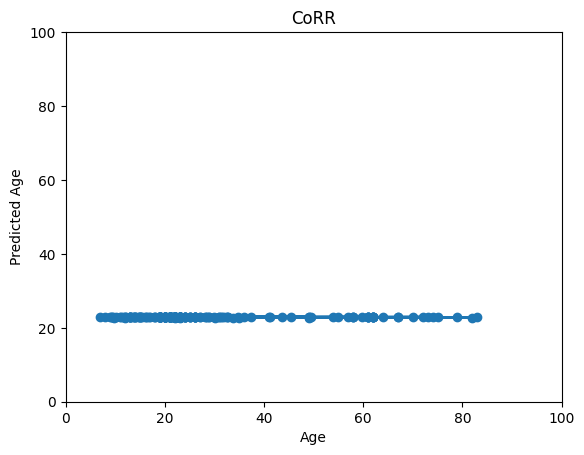

Test MAE: 12.389702796936035 
Test PearsonR & p-value : PearsonRResult(statistic=-0.07841515674469576, pvalue=0.21114294887233861) 


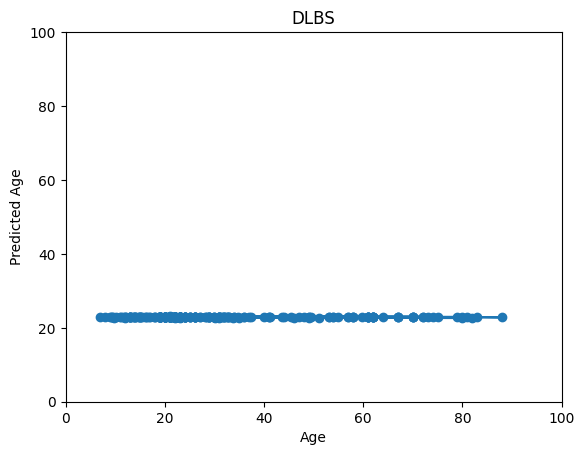

Test MAE: 16.085987091064453 
Test PearsonR & p-value : PearsonRResult(statistic=-0.02511789399224029, pvalue=0.6488768000315615) 


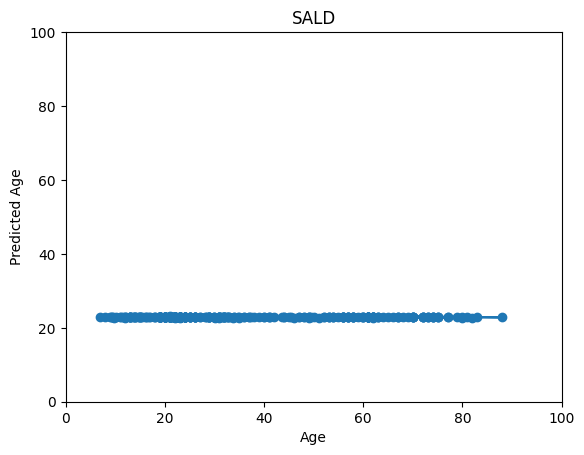

In [27]:
test_mae_list = []
output_list = []
label_list = []
test_loader_list = [corr_test_loader, dlbs_test_loader, sald_test_loader]

# train acc
with torch.no_grad():
    for test_loader in test_loader_list:
        for images, labels in test_loader:
            test_image = images.view(images.shape[0], 1, images.shape[1], images.shape[2],images.shape[3]).to(device, dtype  = torch.float32)
            test_label = labels.to(device)

            test_output = splitnn_client(test_image)
            test_output = splitnn_server(test_output)
            test_label = test_label.long()

            loss = crit(test_output.squeeze(), test_label)
            test_mae_list.append(loss.data)

            # predicted age
            new_tensor = test_output.squeeze().detach().cpu().tolist()
            output_list.append(new_tensor)

            # chronological age
            new_label = labels.detach().cpu().tolist()
            label_list.append(new_label)

            torch.cuda.empty_cache()
 
        output_list = flatten(output_list)
        label_list = flatten(label_list)

        outputs = np.array(output_list)
        labels = np.array(label_list)

            # Calculate R(Correlation)
            # 수정!!! numpy로 계산
        df = pd.DataFrame({
            'Age' : labels,
            'output' : outputs
        })
        df['Diff'] = abs(df['Age'] - df['output'])
        corr = stats.pearsonr(df.Age, df.output)
        df['Corr'] = str(corr)
        
        plt.scatter(labels, outputs)
        if test_loader == corr_test_loader:
            df.to_csv('result_CoRR.csv', index=False)
            plt.title("CoRR")
        elif test_loader == sald_test_loader:
            df.to_csv('result_SALD.csv', index=False)
            plt.title("SALD")
        elif test_loader == dlbs_test_loader:
            df.to_csv('result_DLBS.csv', index=False)
            plt.title("DLBS")
        
        elif test_loader == ixi_test_loader:
            df.to_csv('result_IXI.csv', index=False)
            plt.title("IXI")

        print('Test MAE: {} '.format(sum(test_mae_list)/len(test_mae_list)))
        print('Test PearsonR & p-value : {} '.format(corr))
        
        plt.xlabel('Age')
        plt.ylabel('Predicted Age')
        plt.xlim(0, 100)
        plt.ylim(0, 100)
        plt.plot(labels, outputs)
        plt.show()
        